# Teddy's attempt to formulate the problem

We want to grow some cells and find out their steady state growth rate and yield, among other things.

The normal way to do tis is by running a batch fermentation, which basically means putting some cells and their food in a test tube and then watching to see what happens.

Unfortunately sometimes it's impossible for the cells to get to a steady state in this way. No matter how many cells or how much food you put in the test tube, the cells start to crowd each other out or otherwise generally die rather than doing exponential growth, which is needed for a steady state.

In such cases one solution is to run a fed batch fermentation. Instead of just putting the food and cells in the test tube and then leaving it alone, in this setup food is added continuously and the test tube is emptied at intervals for sampling. By controlling the conditions online in this way, it is possible to avoid the crowding out and see the cells doing exponential growth.

This is great, but there are a couple of catches. First, many analytic tools for fermentation experiments assume a simple batch setup. Rather than re-writing this whole toolbox for the fed batch case, we would like to find a way to transform our fed batch results so that we can apply the existing tools to them. In other words, for every set of fed batch results, we want a set of corresponding "pseudobatch" results. Second, the extra complexity of a fed batch experiment introduces extra sources of error. In particular, the feed pump does not add food perfectly precisely and the human who removes volume for sampling makes some pipetting errors. In order to make the best use of our results, we need to account for these new sources of error.

Both of these problems are surmountable - in fact we have made a pseudobatch transformation rule and a statistical model describing the error situation.

## Setup

We assume there is a container with a large volume. Inside the container there is some liquid (initial volume $V_0$) in which is uniformly dissolved some glucose, biomass and carbon dioxide. At certain times the container is sampled, at which point some liquid is removed, and the biomass, glucose and C02 are measured. During the whole time, feed is added continuously using a pump, with an exponentially increasing feeding rate. This setup accommodates for the exponentially growing biomass, by exponentially increasing feeding rate each cell always has the same amount of food available and thus the growth rate is maintained at a constant level.

## Pseudobatch transformation
Our method for obtaining a pseudobatch glucose concentration $G^{\star}_k$ at step $k$ is as follows:

$$
G^{\star}_k = ADF_k \cdot C^{glucose}_k - \sum_{i=1}^{k-1}ADF_i\frac{C_{feed}\cdot F_{i}}{V_i}
$$

Where


- $C^{glucose}_k$ is the real glucose concentration at step $k$
- $C_{feed}$ is the concentration of glucose in the feed. This is 93.75 in Tim's spreadsheet
- $F_k$ is the volume of liquid pumped in between step $k-1$ and step $k$
- $S_k$ is the volume of liquid removed at step $k$
- $V_k=V_{0} + \sum_{j=1}^{k}F_j - \sum_{j=1}^{k-1}S_j$ is the volume of liquid in the container just before sample $k$ is taken (Comment from Viktor: I added a summation feed, because it is the accumulated feed until time k)
- $ADF_k = \prod_{i=1}^{k}\frac{V_{k-1}}{V_k}$, the accumulated dilution factor, is used to transform concentrations into volumes.



## Statistical model
Our statistical model has the following unknowns:

- $V_0$, the initial volume
- $F$, the vector of feed volumes (one per interval)
- $S$, the vector of sample volumes (one per sample)
- $C_{feed}$, the concentration of glucose in the feed
- $C_{glucose}$, the vector of real glucose concentrations
- $\alpha_{pump}$, the multiplicative bias of the pump in percent

It has the following measurements:

- $y_{glucose}$: direct measurements of the glucose concentration
- $y_{V_{0}}$ measurement of initial volume
- $y_{S_{k}}$ measurement of volume for sample

In addition the following quantities are assumed to be known exactly:
- $F^{target}$ a vector of feed targets for each interval

The model assumes that these measurements are related to the true values of the things measured as follows:

- $y_{glucose} \sim LN(\ln{C_{glucose}}, \sigma_{glucose})$
- $y_{V_{0}}\sim LN(\ln{V_{0}}, \sigma_{V_{0}})$
- $y_{S_{k}} \sim LN(\ln{S_k}, \sigma_{S_k})$

Comment from Viktor: Lars strongly believes that the error of the fed volume is mostly dominated by a constant bias, i.e. rather that the feed volume sometime will be above the target and sometimes below, he thinks that it is likely the pump, for example, will feed 5% too much constantly. Thus, for one MCMC sample the bias should be the same.

The unknown quantities have the following prior distributions:

- $V_0 \sim LNQ99()$
- $\alpha_{pump} \sim NQ99(0.9, 1.1)$
- $\ln{F} \sim N(\ln{F^{target}} + \alpha_{pump}, \sigma_{pump})$
- $S \sim LNQ99()$
- $C_{feed} \sim LNQ99()$
- $C_{glucose} \sim LNQ99(0.0001, 0.1)$

Where $LNQ99(a, b)$ and $NQ99(a, b)$ respectively denote the lognormal and normal distributions with 0.5% and 99.5% quantiles $a$ and $b$.

## Demo
The first bit of code does some boilerplate tasks: loading modules, defining hardcoded variables and loading a test dataset.

In [34]:
import os

import pandas as pd

from matplotlib import pyplot as plt

from pseudobatch.data_correction import dilution_factor_correction

FEDBATCH_FILE = os.path.join("..", "tests", "test_data", "fed-batch3.csv")

fedbatch_df = pd.read_csv(FEDBATCH_FILE, index_col=0)

fedbatch_df.head()

,m_Glucose,m_Biomass,m_Ethanol,m_CO2,v_volume,v_feed_accum,timestamp,sample_volume,True growth rate
0,0.000000,288.000000,0.0,0.000000e+00,800.000000,0.000000,0.000000,NaN,0.000000
1,0.001414,288.000000,0.0,6.749071e-10,800.000015,0.000015,0.000013,NaN,0.000004
2,0.015553,288.000001,0.0,8.164807e-08,800.000166,0.000166,0.000146,NaN,0.000039
3,0.156673,288.000083,0.0,8.298003e-06,800.001674,0.001674,0.001472,NaN,0.000391
4,1.542043,288.008157,0.0,8.157389e-04,800.016771,0.016771,0.014729,NaN,0.003806


The next cell draws a simple plot of this dataset

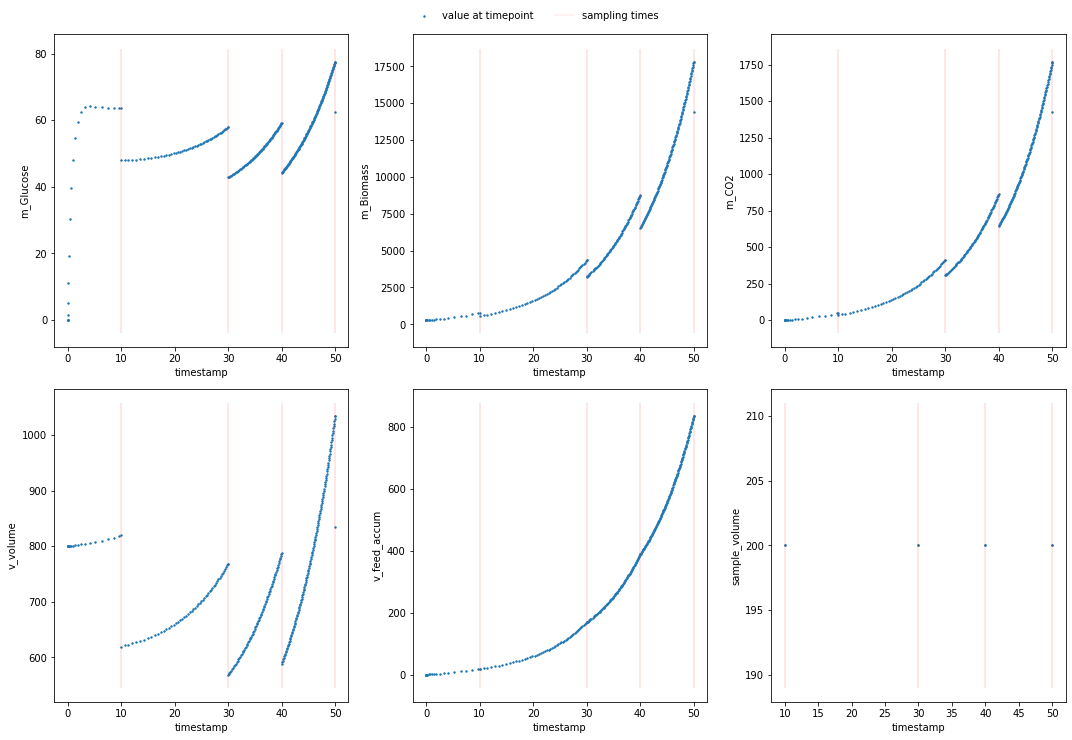

In [39]:
f, axes = plt.subplots(2, 3, figsize=[15, 10])
axes = axes.ravel()

cols_to_plot = ["m_Glucose", "m_Biomass", "m_CO2", "v_volume", "v_feed_accum", "sample_volume"]

sample_ix = fedbatch_df.dropna(subset=["sample_volume"]).index

for ax, col in zip(axes, cols_to_plot):
    labels = ax.set(xlabel="timestamp", ylabel=col)
    scatter = ax.scatter(fedbatch_df["timestamp"], fedbatch_df[col], s=2)
    vlines = ax.vlines(fedbatch_df.loc[sample_ix, "timestamp"], *ax.get_ylim(), color="red", lw=0.1)

legend = f.legend(
    [scatter, vlines], 
    ["value at timepoint", "sampling times"], 
    loc="upper center",
    bbox_to_anchor=[0.5, 1.03],
    ncol=2,
    frameon=False
)
f.tight_layout()